Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and NetID below:

In [1]:
NAME = "Punit K. Jha"
NetID = "punit2"

---

Lab 2: Text Classification
=============

In this problem set, you will build a system for automatically classifying song lyrics comments by era. You will:

- Do some basic text processing, tokenizing your input and converting it into a bag-of-words representation
- Build a machine learning classifier based on the generative model, using Naive Bayes
- Evaluate your classifiers and examine what they have learned
- Build a logistic regression classifier (discriminative model) using PyTorch

Total Points: 100 points

# 0. Setup

In order to develop this assignment, you will need [python 3.6](https://www.python.org/downloads/) and the following libraries. Most if not all of these are part of [anaconda](https://www.continuum.io/downloads), so a good starting point would be to install that.

- [jupyter](http://jupyter.readthedocs.org/en/latest/install.html)
- numpy (This will come if you install scipy like above, but if not install separately)
- [matplotlib](http://matplotlib.org/users/installing.html)
- [nosetests](https://nose.readthedocs.org/en/latest/)
- [pandas](http://pandas.pydata.org/) Dataframes

Here is some help on installing packages in python: https://packaging.python.org/installing/. You can use ```pip --user``` to install locally without sudo.

## About this assignment

- This is a Jupyter notebook. You can execute cell blocks by pressing control-enter.
- Most of your coding will be in the python source files in the directory ```gtnlplib```. Some functions in these source files will remain empty, and we will not touch them. Do not worry about that, and do not assume you are doing something wrong.
- The directory ```tests``` contains unit tests that will be used to grade your assignment, using ```nosetests```. You should run them as you work on the assignment to see that you're on the right track. You are free to look at their source code, if that helps -- though most of the relevant code is also here in this notebook. Learn more about running unit tests at http://pythontesting.net/framework/nose/nose-introduction/
- You may want to add more tests, but that is completely optional. 
- **To submit this assignment, rename the whole directory as your NetID. Compress the whole directory using tar or zip, and submit ```Your_NetID.tgz``` or ```Your_NetID.zip``` on Compass.**

In [2]:
import sys
from importlib import reload

In [3]:
print('My Python version')

print('python: {}'.format(sys.version))

My Python version
python: 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [4]:
import nose

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch import optim

%matplotlib inline

In [5]:
print('My library versions')

print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('scipy: {}'.format(sp.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('nose: {}'.format(nose.__version__))
print('torch: {}'.format(torch.__version__))

My library versions
pandas: 0.25.1
numpy: 1.17.2
scipy: 1.3.1
matplotlib: 3.1.1
nose: 1.3.7
torch: 1.4.0


To test whether your libraries are the right version, run:

`nosetests tests/test_environment.py`

In [6]:
# use ! to run shell commands in notebook
! nosetests tests/test_environment.py

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


# 1. Preprocessing

**Total: 15 points**

Read the data into a dataframe

In [7]:
df_train = pd.read_csv('lyrics-train.csv')

A dataframe is a structured representation of your data. You can preview a dataframe using `head()`

In [8]:
df_train.head()
# print(df_train[0:20])
print(df_train['Era'].values)

['pre-1980' '1980s' 'pre-1980' ... '1980s' '2000s' '1990s']


## Bags of words

Your first task is to convert the text to a bag-of-words representation. For this data, a lot of the preprocessing is already done: the text is lower-cased, and punctuation is removed. You need only create a `counter` for each instance.

- **Deliverable 1.1**: Complete the function `gtnlplib.preproc.bag_of_words`. (5 points)
- **Test**: `nose tests/test_preproc.py:test_d1_1_bow`

In [9]:
from gtnlplib import preproc

In [10]:
# run this block to update the notebook as you change the preproc library
reload(preproc);

In [11]:
y_tr,x_tr = preproc.read_data('lyrics-train.csv',preprocessor=preproc.bag_of_words)
y_dv,x_dv = preproc.read_data('lyrics-dev.csv',preprocessor=preproc.bag_of_words)

In [12]:
y_te,x_te = preproc.read_data('lyrics-test-hidden.csv',preprocessor=preproc.bag_of_words)
! nosetests tests/test_preproc.py:test_d1_1_bow

.
----------------------------------------------------------------------
Ran 1 test in 67.061s

OK


## Unseen words

One challenge for classification is that words will appear in the test data that do not appear in the training data. Compute the number of words that appear in `lyrics-dev.csv`, but not in `lyrics-train.csv`. To do this, implement the following deliverables:

- **Deliverable 1.2**: implement `gtnlplib.preproc.compute_oov`, returning a list of words that appear in one list of bags-of-words, but not another.  (5 points)
- **Tests**: `tests/test_preproc.py:test_d1_3a_oov`

In [13]:
from collections import Counter

In [14]:
reload(preproc);

To write fast code, you can find bottlenecks using the %%timeit cell magic. (The following line will run for about 5 mins.)

In [15]:
%%timeit
preproc.aggregate_counts(x_tr)

1min 1s ± 771 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
counts_dv = preproc.aggregate_counts(x_dv)

You can see the most common items in a counter by calling `counts.most_common()`:

In [17]:
counts_dv.most_common(5)

[('you', 5542), ('i', 5535), ('the', 5061), ('to', 3203), ('and', 2953)]

In [18]:
counts_tr = preproc.aggregate_counts(x_tr)

In [19]:
len(preproc.compute_oov(counts_dv,counts_tr))
# print((counts_dv))

2677

In [20]:
len(preproc.compute_oov(counts_tr,counts_dv))

30459

In [21]:
preproc.oov_rate(counts_dv,counts_tr)

0.297246280257606

In [22]:
! nosetests tests/test_preproc.py:test_d1_1_bow

.
----------------------------------------------------------------------
Ran 1 test in 67.111s

OK


30% of the words in the dev set do not appear in the training set.

## Pruning the vocabulary

Let's prune the vocabulary to include only words that appear at least ten times in the training data.

- **Deliverable 1.3:** Implement `preproc.prune_vocabulary` (5 points)
- **Test**: `tests/test_preproc.py:test_d1_4_prune`

In [23]:
reload(preproc);

In [24]:
x_tr_pruned, vocab = preproc.prune_vocabulary(counts_tr,x_tr,10)
x_dv_pruned, _ = preproc.prune_vocabulary(counts_tr,x_dv,10)
x_te_pruned, _ = preproc.prune_vocabulary(counts_tr,x_te,10)


In [25]:
len(vocab)

4875

In [26]:
i = 94
print(len(x_dv[i]),len(x_dv_pruned[i]))
print(sum(x_dv[i].values()),sum(x_dv_pruned[i].values()))
! nosetests tests/test_preproc.py:test_d1_4_prune

88 79
187 176
.
----------------------------------------------------------------------
Ran 1 test in 89.185s

OK


# 2. Linear classification

Now we'll show you how to implement the linear classification rule, $\hat{y} = \text{argmax}_y \theta^{\top} f(x,y)$.

You will use these functions in all classifiers in this assignment.

In [27]:
from gtnlplib import clf_base
reload(clf_base)

from gtnlplib import constants
reload(constants);

The feature function vector $f(x,y)$ can be viewed as a dict, in which the values are counts, and the keys are tuples $(y,x_j)$, where $y$ is a label and $x_j$ is a base feature. Note that we must also include the offset feature, ```gtnlplib.constants.OFFSET```. Desired output is shown below:

In [28]:
fv = clf_base.make_feature_vector({'test':1,'case':2},'1980s')

In [29]:
print(fv)

{('1980s', 'test'): 1, ('1980s', 'case'): 2, ('1980s', '**OFFSET**'): 1}


Let's compute the entire set of labels.

In [30]:
labels = set(y_tr) #figure out all possible labels
print(labels)

{'1980s', 'pre-1980', '2000s', '1990s'}


In [31]:
! nosetests tests/test_classifier.py:test_d2_1_featvec

.
----------------------------------------------------------------------
Ran 1 test in 76.041s

OK


Now we implement the prediction rule, $\hat{y} = \text{argmax}_y \theta^{\top} f(x,y)$.

The output should be:

- A predicted label
- The scores of all labels

You can test this function using these simple hand-crafted weights.

In [32]:
from collections import defaultdict
reload(clf_base)

<module 'gtnlplib.clf_base' from '/home/punit/Desktop/Machine_Learning/ECE_365/NLP_Lab2/punit2/NLPLab2/gtnlplib/clf_base.py'>

In [33]:
# weight vectors must be defaultdicts
theta_hand = defaultdict(float,
                         {('2000s','money'):0.1,
                          ('2000s','name'):0.2,
                          ('1980s','tonight'):0.1,
                          ('2000s','man'):0.1,
                          ('1990s','fly'):0.1,
                          ('pre-1980',constants.OFFSET):0.1
                         })

In [34]:
clf_base.predict(x_tr_pruned[0],theta_hand,labels)

('2000s',
 {'1980s': 0.0, 'pre-1980': 0.1, '2000s': 1.3000000000000003, '1990s': 0.0})

Now let's see how good these weights are, by evaluating on the dev set.

In [35]:
from gtnlplib import evaluation
reload(evaluation);

In [36]:
# this applies your predict function to all the instances in ```x_dv```
y_hat = clf_base.predict_all(x_dv_pruned,theta_hand,labels)
print(evaluation.acc(y_hat,y_dv))

0.3422222222222222


In [37]:
! nosetests tests/test_classifier.py:test_d2_2_predict

.
----------------------------------------------------------------------
Ran 1 test in 82.032s

OK


# 3. Naive Bayes

You'll now implement a Naive Bayes classifier in this section.

**Total: 40 points**

In [38]:
from gtnlplib import naive_bayes
reload(naive_bayes);

- **Deliverable 3.1**: (warmup) implement ```get_corpus_counts``` in ```naive_bayes.py```. (5 points)
- **Test**: `tests/test_classifier.py:test_d3_1_corpus_counts`

This function should compute the word counts for a given label.

In [39]:
eighties_counts = naive_bayes.get_corpus_counts(x_tr_pruned,y_tr,"1980s");
print(eighties_counts['today'])
print(eighties_counts['yesterday'])
print(eighties_counts['internets'])
# print(eighties_counts)
! nosetests tests/test_classifier.py:test_d3_1_corpus_counts

50
14
0.0
.
----------------------------------------------------------------------
Ran 1 test in 75.156s

OK


- **Deliverable 3.2**: Implement ```estimate_pxy``` in ```naive_bayes.py```. (15 points)
- **Test**: `tests/test_classifier.py:test_d3_2_pxy`

This function should compute the *smoothed* multinomial distribution $\log P(x \mid y)$ for a given label $y$.
Note that this function takes the vocabulary as an argument. You have to assign a probability even for words that do not appear in documents with label $y$, if they are in the vocabulary.

Hint: You can use ```get_corpus_counts``` in this function if you want to, but you don't have to.

In [40]:
# print((vocab))
reload(naive_bayes);
log_pxy = naive_bayes.estimate_pxy(x_tr_pruned,y_tr,"1980s",0.1,vocab)

Probabilities must sum to one! (or very close)

In [41]:
sum(np.exp(list(log_pxy.values())))
# print(log_pxy)

0.9999999999999506

Let's look at the log-probabilities of the words from the hand-tuned weights

In [42]:
print({word:log_pxy[word] for (_,word),weight in theta_hand.items() if weight>0})

{'money': -7.689562807416732, 'name': -7.568324713816848, 'tonight': -6.216637557007502, 'man': -6.63187694645784, 'fly': -8.636944126360918, '**OFFSET**': 0.0}


In [43]:
log_pxy_more_smooth = naive_bayes.estimate_pxy(x_tr_pruned,y_tr,"1980s",1000,vocab)

In [44]:
print({word:log_pxy_more_smooth[word] for (_,word),weight in theta_hand.items() if weight>0})
! nosetests tests/test_classifier.py:test_d3_2_pxy

{'money': -8.443741629859995, 'name': -8.43282250408468, 'tonight': -8.191919045665923, 'man': -8.295226983039361, 'fly': -8.497300695217104, '**OFFSET**': 0.0}
.
----------------------------------------------------------------------
Ran 1 test in 75.059s

OK


- **Deliverable 3.3**: Now you are ready to implement ```estimate_nb``` in ```naive_bayes.py```. (15 points)
- **Test**: `tests/test_classifier.py:test_d3_3a_nb`



- The goal is that the score given by ```clf_base.predict``` is equal to the joint probability $P(x,y)$, as described in the notes. Therefore, make sure your return output can be feed into ```clf_base.predict```. 
- Don't forget the offset feature, whose weights should be set to the prior $\log P(y)$.
- The log-probabilities for the offset feature should not be smoothed.
- You can call the functions you have defined above, but you don't have to.

In [45]:
reload(naive_bayes);
theta_nb = naive_bayes.estimate_nb(x_tr_pruned,y_tr,0.1)

In [46]:
print(len(theta_nb))

19504


Let's predict for a single instance. 

In [47]:
clf_base.predict(x_tr_pruned[155],theta_nb,labels)

('2000s',
 {'1980s': -2153.019927798136,
  'pre-1980': -2136.8348423968023,
  '2000s': -2099.247401056139,
  '1990s': -2125.1966084804503})

Let's predict for all instances of the development set. 

In [48]:
y_hat = clf_base.predict_all(x_dv_pruned,theta_nb,labels)
print(evaluation.acc(y_hat,y_dv))

0.46444444444444444


In [49]:
# this block shows how we write and read predictions for evaluation
evaluation.write_predictions(y_hat,'nb-dev.preds')
y_hat_dv = evaluation.read_predictions('nb-dev.preds')
evaluation.acc(y_hat_dv,y_dv)

0.46444444444444444

In [50]:
# execute this block to write predictions for the test set
y_hat = clf_base.predict_all(x_te_pruned,theta_nb,labels)
evaluation.write_predictions(y_hat,'nb-test.preds')
! nosetests tests/test_classifier.py:test_d3_3a_nb

.
----------------------------------------------------------------------
Ran 1 test in 91.685s

OK


- **Deliverable 3.4**: Write a function in ```naive_bayes.py``` called ```find_best_smoother```, which finds the smoothing value that gives best performance on the dev data.  (5 points)
- **Test**: `tests/test_classifier.py:test_d3_4a_nb_best`

Your function should be trying at least the following values in `vals` below.

Then, using this smoothing value, run your Naive Bayes classifier on the test set, and output the results.

In [51]:
vals = np.logspace(-3,2,11)
print(vals)

[1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02]


In [52]:
reload(naive_bayes);
best_smoother, scores = naive_bayes.find_best_smoother(x_tr_pruned,y_tr,x_dv_pruned,y_dv,vals)

In [53]:
print(scores)
print(best_smoother)

{0.001: 0.44666666666666666, 0.0031622776601683794: 0.45111111111111113, 0.01: 0.4577777777777778, 0.03162277660168379: 0.45555555555555555, 0.1: 0.46444444444444444, 0.31622776601683794: 0.4622222222222222, 1.0: 0.45111111111111113, 3.1622776601683795: 0.4688888888888889, 10.0: 0.4666666666666667, 31.622776601683793: 0.32666666666666666, 100.0: 0.28888888888888886}
0.28888888888888886


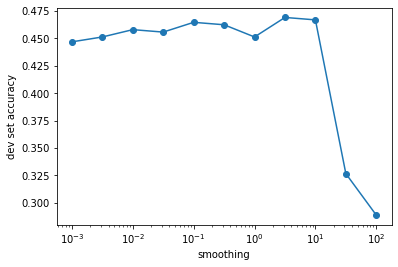

In [54]:
plt.semilogx(list(scores.keys()),list(scores.values()),'o-');
plt.xlabel('smoothing')
plt.ylabel('dev set accuracy');

**Reflect:**

- what might explain the dramatic drop in accuracy when the smoothing is increased from $10$ to $30$?
- before you check, predict whether the accuracy will continue to significantly drop if you further increase the smoothing to $10000$.

**Your Answer Here**: 

Save the best parameters for later comparison. 

In [55]:
theta_nb = naive_bayes.estimate_nb(x_tr_pruned,y_tr,best_smoother)
y_hat = clf_base.predict_all(x_te_pruned,theta_nb,labels)
evaluation.write_predictions(y_hat,'nb-best-test.preds')

In [56]:
! nosetests tests/test_classifier.py:test_d3_4a_nb_best

.
----------------------------------------------------------------------
Ran 1 test in 122.151s

OK


# 4. Logistic regression

You will implement logistic regression in scikit-learn.

**Total: 15 points**


## 4.1 Converting data to numpy

Numpy is a package for numerical computing in python.

You will need to convert your bag-of-words list of counters to a numpy array. 

- **Deliverable 4.1**: Implement `preproc.py:make_numpy()` (5 points)
- **Test**: `test_pytorch/test_d5_1_numpy`
- **Hint**: one approach is to start with `numpy.zeros((height,width))`, and then fill in the cells by iterating through the bag-of-words list

In [57]:
X = np.zeros((4,2))
print(X)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [58]:
X[1,1] = -1
X[2,0] = 1.5
print(X)

[[ 0.   0. ]
 [ 0.  -1. ]
 [ 1.5  0. ]
 [ 0.   0. ]]


In [59]:
reload(preproc);

In [60]:
reload(preproc);
X_tr = preproc.make_numpy(x_tr_pruned,vocab)
X_dv = preproc.make_numpy(x_dv_pruned,vocab)
X_te = preproc.make_numpy(x_te_pruned,vocab)

In [61]:
print(len(x_te_pruned))
print(len(vocab))
print(np.shape(X_te))
print(X_te[3])

450
4875
(450, 4875)
[0. 0. 0. ... 0. 0. 0.]


In [62]:
label_set = sorted(list(set(y_tr)))
print(label_set)

['1980s', '1990s', '2000s', 'pre-1980']


In [63]:
Y_tr = np.array([label_set.index(y_i) for y_i in y_tr])
Y_dv = np.array([label_set.index(y_i) for y_i in y_dv])

In [64]:
len(set(Y_tr))

4

In [65]:
! nosetests  tests/test_pytorch.py:test_d5_1_numpy
# tests/test_classifier.py:test_d3_4a_nb_best

.
----------------------------------------------------------------------
Ran 1 test in 84.409s

OK


## 4.2 Building a logistic regression model

Import the model you want to use and make an instance of the Model.

In [66]:
from sklearn.linear_model import LogisticRegression
scikit_log_reg = LogisticRegression(solver='liblinear',max_iter=1000,multi_class='auto')#shows warning messages without these specifications

Logistic Regression Model training.

In [67]:
logisticRegr=scikit_log_reg.fit(X_tr, Y_tr)

Get accuracy of training data and dev data. 

accuracy is defined as:

(fraction of correct predictions): correct predictions / total number of data points

In [68]:
train_acc = logisticRegr.score(X_tr, Y_tr)
dev_acc = logisticRegr.score(X_dv, Y_dv)

print(train_acc)
print(dev_acc)
print()


0.99
0.47333333333333333



**Deliverable 4.2**
The noisy progress of the loss and dev set accuracy suggests that something is wrong with our training hyperparameters. Tune the ```LogisticRegression``` parameters until you can get to a dev set accuracy of at least 0.5. You may find a set of tunable parameters here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 
(10 points)

In [69]:
def better_model():
    x=np.linspace(0.0001,0.8,30)
    dev_acc=np.zeros(len(x))
    for i,c in enumerate(x):
        scikit_log_reg.C=c
        logisticRegr=scikit_log_reg.fit(X_tr, Y_tr)
        dev_acc[i] = logisticRegr.score(X_dv, Y_dv)
    opti=x[np.argmax(dev_acc)]
    scikit_log_reg.C=opti
    return scikit_log_reg
print("Decreasing the value of regularization parameters helps to increase the dev set accuracy  since regularization decreases overfitting and increases accuracy on the test set")

Decreasing the value of regularization parameters helps to increase the dev set accuracy  since regularization decreases overfitting and increases accuracy on the test set


In [70]:
scikit_log_reg = better_model()
logisticRegr=scikit_log_reg.fit(X_tr, Y_tr)
train_acc = logisticRegr.score(X_tr, Y_tr)
dev_acc = logisticRegr.score(X_dv, Y_dv)
print(train_acc)
print(dev_acc)

0.90725
0.5266666666666666


In [71]:
Y_hat_te = logisticRegr.predict(X_te)
np.save('logreg-es-test.preds.npy', np.array(Y_hat_te))

# 5. Feature analysis

**Total: 20 points**


## 5.1 Top Features for Logistic Regression

**Deliverable 5.1**: Implement ```get_top_features_LR``` to output the k most indicative features (**highest features weights**) and the k least indicative features (**lowest features weights**) for each label. (10 points)

**Hint**: ```scikit_log_reg.coef_``` is the coefficient of the features. 

Let's load the vanilla LR model for comparison. 

In [72]:
scikit_log_reg = LogisticRegression(solver='liblinear',max_iter=1000,multi_class='auto')#shows warning messages without these specifications
logisticRegr=scikit_log_reg.fit(X_tr, Y_tr)


In [73]:
print(Y_tr.shape)

(4000,)


In [75]:
def get_top_features_LR(scikit_log_reg, vocab,label_set,label,k):
    most_indicative_features = []
    least_indicative_features = []
    lls={}
    for i,x in enumerate(label_set):
        lls[x]=i
    vocab=sorted(vocab) #since a sorted vocab was used while creating the LR numpy theta matrix
                      
    
    coefs=scikit_log_reg.coef_ #each coefficient corresponds to the corresponding element in the vocab list
    
    Z = [x for _,x in sorted(zip(coefs[lls[label]],vocab))]
#     print(vocab,coefs[lls[label]])
    most_indicative_features=Z[-k:]
    least_indicative_features=Z[:k]
    return most_indicative_features, least_indicative_features
    
print(get_top_features_LR(scikit_log_reg, vocab,label_set,'pre-1980',k=10))
print(get_top_features_LR(scikit_log_reg, vocab,label_set,'1980s',k=10))
print(get_top_features_LR(scikit_log_reg, vocab,label_set,'1990s',k=10))
print(get_top_features_LR(scikit_log_reg, vocab,label_set,'2000s',k=10))

(['ticket', 'moments', 'tall', 'gentle', 'lord', 'layin', 'mornin', 'grows', 'hardly', 'hoped'], ['NA', 'front', 'needed', 'truth', 'wishing', 'hit', 'sick', 'kids', 'perfect', 'yo'])
(['finer', 'againi', 'emotional', 'madness', 'answers', 'lawyers', 'beneath', 'thinks', 'shout', 'america'], ['melt', 'lord', 'begun', 'begin', 'mood', 'opened', 'heavens', 'miles', 'snow', 'tree'])
(['scream', 'invisible', 'yeaall', 'mase', 'hit', 'unless', 'thang', 'outside', 'jealousy', 'NA'], ['second', 'miscellaneous', 'broke', 'guitar', 'clean', 'realized', 'meaning', 'pick', 'onto', 'changing'])
(['animals', 'shorty', 'independent', 'separate', 'windmill', 'itbaby', 'locked', 'editor', 'shut', 'three'], ['fool', 'playing', 'pimp', 'survive', 'beneath', 'comin', 'rhythm', 'foolish', 'although', 'wall'])


## 5.2 Top Features for Naive Bayes


**Deliverable 5.2**: Implement ```get_top_features_NB``` to output the k most indicative features (**highest features weights**) and the k least indicative features (**lowest features weights**) for each label. (10 points)

**Hint**: ```scikit_log_reg.coef_``` is the coefficient of the features. 

In [76]:
def get_top_features_NB(theta_nb, label_set,label,k):
    features={}
    most_indicative_features = []
    least_indicative_features = []
    for x,y in theta_nb.keys():
        if(x==label):
            features[y]=theta_nb[(x,y)]
    del features['**OFFSET**']
    features={k: v for k, v in sorted(features.items(), key=lambda item: item[1])}
#     print(features)
    least_indicative_features=list(features.keys())[:k]
    most_indicative_features=list(features.keys())[-k:]
    return most_indicative_features, least_indicative_features

print(get_top_features_NB(theta_nb, label_set,'pre-1980',k=10))
print(get_top_features_NB(theta_nb, label_set,'1980s',k=10))
print(get_top_features_NB(theta_nb, label_set,'1990s',k=10))
print(get_top_features_NB(theta_nb, label_set,'2000s',k=10))

(['love', 'it', 'my', 'me', 'a', 'and', 'to', 'i', 'the', 'you'], ['producer', 'ayer', 'ayayer', 'cd', 'shawty', 'dj', 'wop', 'morn', 'crunk', 'tha'])
(['love', 'my', 'it', 'and', 'a', 'me', 'to', 'i', 'the', 'you'], ['sally', 'shoutin', 'yellin', 'starry', 'ba', 'reflection', 'youall', 'ayer', 'ayayer', 'cd'])
(['your', 'my', 'it', 'a', 'and', 'me', 'to', 'the', 'i', 'you'], ['sue', 'shoutin', 'starry', 'drives', 'ayer', 'ayayer', 'shawty', 'morn', 'stuntin', 'fights'])
(['in', 'my', 'it', 'a', 'to', 'and', 'me', 'the', 'i', 'you'], ['sally', 'shoutin', 'starry', 'hooray', 'jojo', 'native', 'miggida', 'wayif', 'sleepy', 'lovewhen'])


**Reflect:**

- Compare the development dataset accuracy of LR and NB, which model do you think is better? 
- Given those indicative features of LR and NB, which model do you think is better? 
- You may read https://medium.com/@sangha_deb/naive-bayes-vs-logistic-regression-a319b07a5d4c for more information on a comparison between discriminative and generative models. 

**Your Answer Here**: I think the LR model is better in this case.

# 6. Precision, Recall, and F1

Besides accuracy, systems in natural language processing are evaluated using precision, recall, and F1. Such measures are essential when evaluating on an unbalanced dataset in terms of classes (labels). 

**Total: 10 points**

## Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of data for which the true values are known. 

In this section, we show one python packages (Seaborn) for making confusion matrixes.

In [77]:
from sklearn import metrics
import seaborn as sns

predictions = logisticRegr.predict(X_dv)
cm = metrics.confusion_matrix(Y_dv, predictions)


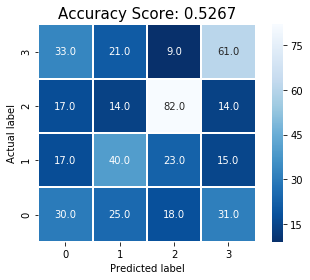

In [78]:
plt.figure()
ax = sns.heatmap(cm, annot=True, fmt=".1f", linewidths=1, square = True, cmap = 'Blues_r');
ax.set_ylim(0 ,4)
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(dev_acc)
plt.title(all_sample_title, size = 15);
plt.show();

**Reflect**: What do you observe on the above confusion matrix? If you are the leading manager for this team project, which portion of the data would you ask your team to focus on? 

**Your Answer Here**:  In the above confusion matrix, I observe that the predictions for classes for different X_dv values(rows or data points) and the actual class it belongs to. The left-diagonal part of the matrix is for the classes that are classified correctly, and all other parts are the ones classified incorrectly. I see that data points in class 0  ('pre-1980') has been classified the least accurately. So I would ask my team to focus on class 0 followed by class 1. Class 2 and 3 both have higher accuracy of classification.

## Precision, Recall, and F1

Write a function below that takes in a predicted labels 'Y_hat' and gold labels 'Y', and returns the precision, recall, and F1 for each label.

F1 is the harmonic mean of precision and recall. F1 = 2 * (precision * recall) / (precision + recall)

(10 points)

In [79]:
def get_PRF(Y_hat_dv, Y_dv, label_set, label):
    precision = 0.0
    recall = 0.0
    f1 = 0.0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    lls={}
    for i,x in enumerate(label_set):
        lls[x]=i
    cor=lls[label]
    for i in range(len(y_hat)): 
        if Y_dv[i]==Y_hat_dv[i]==cor:
               TP+= 1
        if Y_hat_dv[i]==cor and Y_dv[i]!= cor:
               FP += 1
        if Y_dv[i]==Y_hat_dv[i]!= cor:
               TN += 1
        if Y_hat_dv[i] !=  cor and Y_dv[i]!=cor:
               FN += 1
 
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    f1=(2*precision*recall)/(precision+recall)
    return precision, recall, f1
print(label_set)
print(get_PRF(predictions, Y_dv, label_set, 'pre-1980'))
print(get_PRF(predictions, Y_dv, label_set, '1980s'))
print(get_PRF(predictions, Y_dv, label_set, '1990s'))
print(get_PRF(predictions, Y_dv, label_set, '2000s'))

['1980s', '1990s', '2000s', 'pre-1980']
(0.5041322314049587, 0.18654434250764526, 0.27232142857142855)
(0.30927835051546393, 0.0970873786407767, 0.14778325123152708)
(0.4, 0.11940298507462686, 0.1839080459770115)
(0.6212121212121212, 0.23098591549295774, 0.33675564681724846)
